<h1>Import the Required Libraries</h1>

In [119]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [120]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [121]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [122]:
data = read_text("../input/bilingual-sentence-pairs/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [123]:
deu_eng = deu_eng[:50000,:]

In [124]:
N = 50000
data = pd.read_csv("../input/train-dataset/filtered.tsv", sep='\t').iloc[:N]
for i in range(len(data)):
    if i % 1000==0:
        print(f"{100*i/N}% completed")
    if data.iloc[i, 5] < data.iloc[i, 6]:
        # Do swap
        z = data.iloc[i, 1]
        data.iloc[i, 1] = data.iloc[i, 2]
        data.iloc[i, 2] = z

        z = data.iloc[i, 5]
        data.iloc[i, 5] = data.iloc[i, 6]
        data.iloc[i, 6] = z
data = data[["reference", "translation"]]
data.head(3)

0.0% completed
2.0% completed
4.0% completed
6.0% completed
8.0% completed
10.0% completed
12.0% completed
14.0% completed
16.0% completed
18.0% completed
20.0% completed
22.0% completed
24.0% completed
26.0% completed
28.0% completed
30.0% completed
32.0% completed
34.0% completed
36.0% completed
38.0% completed
40.0% completed
42.0% completed
44.0% completed
46.0% completed
48.0% completed
50.0% completed
52.0% completed
54.0% completed
56.0% completed
58.0% completed
60.0% completed
62.0% completed
64.0% completed
66.0% completed
68.0% completed
70.0% completed
72.0% completed
74.0% completed
76.0% completed
78.0% completed
80.0% completed
82.0% completed
84.0% completed
86.0% completed
88.0% completed
90.0% completed
92.0% completed
94.0% completed
96.0% completed
98.0% completed


,reference,translation
0,"if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.","If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters."
1,you're becoming disgusting.,Now you're getting nasty.
2,"well, we can spare your life.","Well, we could spare your life, for one."


In [125]:
deu_eng = data.to_numpy()

<h1> Text Cleaning / Preprocessing</h1>

In [126]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['if Alkar floods her with her mental waste it would explain the high levels of neurotransmitter',
        'If Alkar is flooding her with psychic waste that explains the high level of neurotransmitters'],
       ['youre becoming disgusting', 'Now youre getting nasty'],
       ['well we can spare your life',
        'Well we could spare your life for one'],
       ...,
       ['What a fucking joke', 'really funny'],
       ['we killed those two', 'We have two slain'],
       ['to hell with a world where you cant even trust dogs',
        'A hell of a world where you could not trust dogs']], dtype=object)

In [127]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [129]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [130]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 25650


In [131]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 27708


In [132]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)

    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [133]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [134]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

<h1> Define the Model</h1>

In [135]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [136]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [137]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [138]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=64, validation_split = 0.1, callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
563/563 [==============================] - 71s 118ms/step - loss: 6.1286 - val_loss: 5.5295

Epoch 00001: val_loss improved from inf to 5.52954, saving model to model.h1.24_jan_19
Epoch 2/30
563/563 [==============================] - 65s 116ms/step - loss: 5.4392 - val_loss: 5.2956

Epoch 00002: val_loss improved from 5.52954 to 5.29562, saving model to model.h1.24_jan_19
Epoch 3/30
563/563 [==============================] - 65s 116ms/step - loss: 5.1665 - val_loss: 5.1639

Epoch 00003: val_loss improved from 5.29562 to 5.16392, saving model to model.h1.24_jan_19
Epoch 4/30
563/563 [==============================] - 65s 115ms/step - loss: 4.9289 - val_loss: 5.0475

Epoch 00004: val_loss improved from 5.16392 to 5.04752, saving model to model.h1.24_jan_19
Epoch 5/30
563/563 [==============================] - 65s 115ms/step - loss: 4.7188 - val_loss: 4.9808

Epoch 00005: val_loss improved from 5.04752 to 4.98078, saving model to model.h1.24_jan_19
Epoch 6/30
563/563 [=========

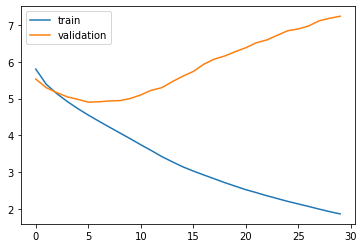

In [139]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

In [140]:
print(testX[0])

[ 141    4  122    1 2565    8   33  262]


In [141]:
model = load_model('model.h1.24_jan_19')
tX = testX.reshape((testX.shape[0],testX.shape[1]))

In [142]:
preds = model.predict_classes(tX[:3,:])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [143]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [144]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [145]:
pred_df = pd.DataFrame({'actual' : test[:3,0], 'predicted' : preds_text})

In [146]:
pred_df.head(15)

,actual,predicted
0,if you want to be certain shoot the gun into your mouth,the a his in his
1,you risk your neck to cut them loose and they run away and dont look back,and dont not back
2,if you got any brains youll break now and dont look back,and back
